# Miles per Gallon

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, ttest_ind, chisquare, f_oneway, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [2]:
df = sns.load_dataset("mpg")
df.dropna(inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
 7   origin        392 non-null    object 
 8   name          392 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 30.6+ KB


#### **0. Variables discrètes et continues**

In [4]:
disc = ["cylinders", "model_year", "origin", "name"]
cont = ["mpg", "displacement", "horsepower", "weight", "acceleration"]

#### **1. Analyse de l'évolution de la consommation des voitures (mpg) par rapport à la puissance du moteur (horsepower)**

##### **1.1 Graphique correspondant**

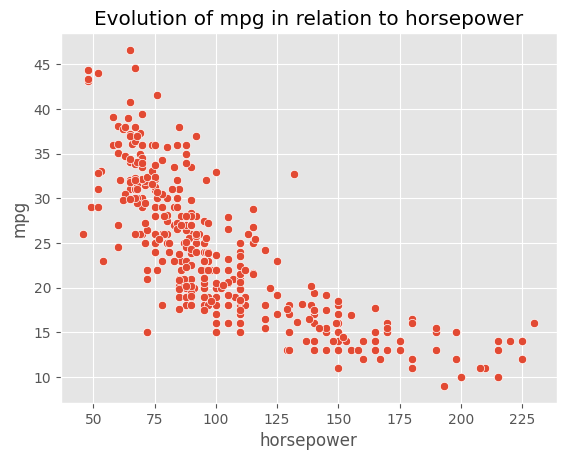

In [5]:
sns.scatterplot(data=df, x="horsepower", y="mpg")
plt.title("Evolution of mpg in relation to horsepower")
plt.show()

##### **1.2 Corrélation de Pearson entre les variables**

- Nous utilisons le test de Pearson pour étudier la corrélation entre ces deux variables continues.

In [6]:
statistic, pvalue = pearsonr(df["horsepower"], df["mpg"])
statistic

np.float64(-0.7784267838977759)

- Les deux variables évoluent de manière quand même assez significative dans des directions opposées

**1.3 Probabilité d'obtenir une telle corrélation ou plus extrême, si en réalité les deux variables étaient totalement décorrélées**

In [7]:
pvalue

np.float64(7.0319890294050415e-81)

- Cette probabilité étant presque nulle, il est impensable de dire que les variables `horsepower` et `mpg` ne seraient pas correlées.

#### **2. Peut-on affirmer avec un risque d'erreur de 2% que les voitures étudiées ont vu leur autonomie moyenne augmenter entre la premiere et la seconde moitié des années 70 ?**

- Nous considérerons les périodes [70; 74] et [75; 79].
- Etant en présence d'une variable continue (`mpg`) et d'une variable discrète (`model_period`, période de production de la voiture), nous choisisons d'utiliser un test de Student à 2 échantillons :
  - Nous supposons que les voitures observées sont idépendantes les unes des autres.
  - Chaque groupe possède +30 points.
  - Les variances sont plutôt différents, nous allons le spécifer dans la fonction de test afin d'utiliser le test de Welsh.
- On pose H0 : "mpg mpyen du groupe [70; 74] = mpg moyen du groupe [74; 79]".

In [8]:
# Observations
tmp_df_1 = df.query("model_year < 80").copy()
tmp_df_1["model_period"] = tmp_df_1["model_year"].apply(
    lambda model_year: "before_75" if model_year < 75 else "after_75"
)

tmp_df_1.groupby("model_period")["mpg"].describe()

,count,mean,std,min,25%,50%,75%,max
model_period,,,,,,,,
after_75,157.0,22.865605,6.442882,13.0,18.0,21.5,27.4,43.1
before_75,150.0,19.220000,5.999855,9.0,14.0,18.0,24.0,35.0


In [9]:
tmp_df_1.groupby("model_period")["mpg"].var()

model_period
after_75     41.510732
before_75    35.998255
Name: mpg, dtype: float64

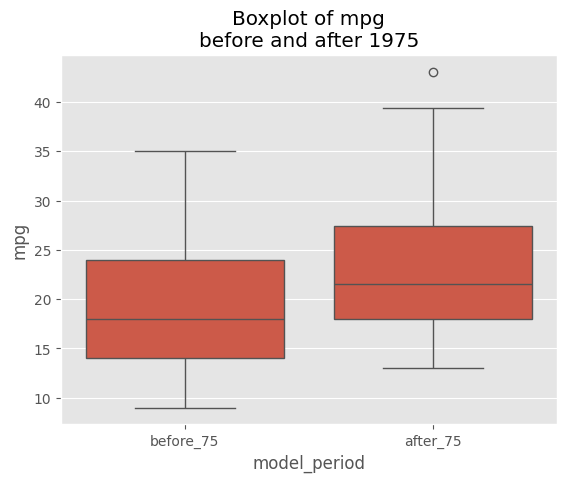

In [10]:
sns.boxplot(data=tmp_df_1, x="model_period", y="mpg")
plt.title("Boxplot of mpg\nbefore and after 1975")
plt.show()

In [11]:
samples = tmp_df_1.groupby("model_period")["mpg"].apply(list)

test_1 = ttest_ind(
    samples["before_75"], samples["after_75"], alternative="less"
)  # alt: less -> first < second
test_2 = ttest_ind(
    samples["before_75"], samples["after_75"], alternative="less", equal_var=False
)  # Welsh

print("Student:", test_1)
print("  Welsh:", test_2)

Student: TtestResult(statistic=np.float64(-5.124844610385172), pvalue=np.float64(2.647552225662162e-07), df=np.float64(305.0))
  Welsh: TtestResult(statistic=np.float64(-5.133189260373369), pvalue=np.float64(2.5426232556922585e-07), df=np.float64(304.80252342094974))


- La p-valeur de ce test étant inférieure à notre seuil de 0,02, nous rejetons H0.
- Peut-on donc affirmer que celle-ci a augmenté ? Devait-on réellement utiliser le `alternative="less"` ? (à voir).

#### **3. Un constructeur automobile américain affirme que les voitures américaines à 4 cylindres ont en moyenne la même accélération que les voitures américaines à 6 cylindres. Testons cette affirmation et concluons avec un niveau de confiance de 98%.**

- Nous utiliserons un test de Student à 2 échantillons indépendants pour comparer les moyennes de la variable continue `acceleration` en fonction de la variable discrète représentant le nombre de cylindres (4 ou 6) :
  - Nous supposons les observations indépendantes entre elles.
  - Nous avons plus de 30 observations.
  - Les variances sont quasi-égales.
- H0 : "Les voitures américaines à 4 cylindres ont en moyenne la même accélération que les voitures américaines à 6 cylindres".

In [12]:
# Observations
tmp_df_2 = df.query("origin == 'usa' & cylinders in [4, 6]")
tmp_df_2.groupby("cylinders")["acceleration"].describe()

,count,mean,std,min,25%,50%,75%,max
cylinders,,,,,,,,
4,69.0,16.465217,2.180989,11.6,14.9,16.2,17.7,22.2
6,73.0,16.467123,1.908974,11.3,15.5,16.4,17.7,21.0


In [13]:
tmp_df_2.groupby("cylinders")["acceleration"].var()

cylinders
4    4.756714
6    3.644182
Name: acceleration, dtype: float64

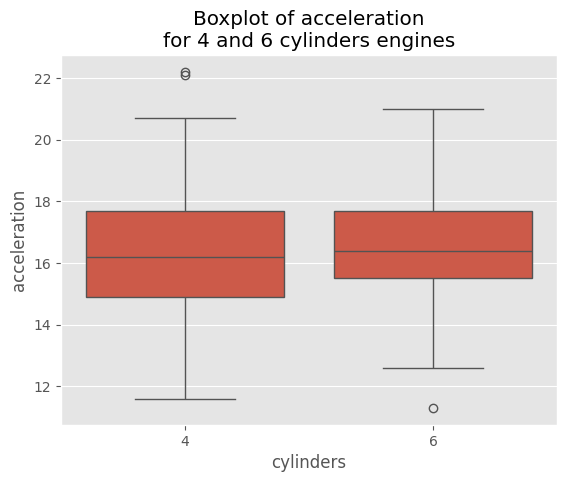

In [14]:
sns.boxplot(data=tmp_df_2, x="cylinders", y="acceleration")
plt.title("Boxplot of acceleration\nfor 4 and 6 cylinders engines")
plt.show()

In [15]:
samples = tmp_df_2.groupby("cylinders")["acceleration"].apply(list)
ttest_ind(samples[4], samples[6])

TtestResult(statistic=np.float64(-0.0055490223717790345), pvalue=np.float64(0.9955804426559065), df=np.float64(140.0))

- Sachant H0, la probabilité d'avoir un des moyennes au moins aussi éloignées (0,0019 d'écart) est largement supérieure à notre seuil (p = 0,9956 >>> alpha = 0,02).
- Nous ne pouvons donc pas rejeter l'hypothèse selon laquelle l'accélération des véhicules américains serait la même pour les 4 et les 6 cylindres. 

#### **4. Un collectionneur de voitures affirme que parmi les voitures Ford des années 1970-1982, il y avait :**

<b>

- 25% de 4 cylindres
- 25% de 6 cylindres
- 50% de 8 cylindres

Testons son affirmation et concluons avec un niveau de confiance de 95%.</b>

- Nous utiliserons un test du Chi-2 pour évaluer la pertinence de ces ratios on les comparant aux proportions observées.

In [16]:
# Observations
tmp_df_3 = df.copy()
tmp_df_3["is_ford"] = df["name"].str.contains("ford", case=False, na=False)
tmp_df_3 = tmp_df_3.query("is_ford == True")["cylinders"]

f_obs = tmp_df_3.value_counts().sort_index()
f_obs

cylinders
4    16
6    12
8    20
Name: count, dtype: int64

In [17]:
# Expected values
f_exp = np.array([0.25, 0.25, 0.5]) * len(tmp_df_3)
f_exp

array([12., 12., 24.])

In [18]:
chisquare(f_obs, f_exp)

Power_divergenceResult(statistic=np.float64(2.0), pvalue=np.float64(0.36787944117144245))

- On a 0,3679 > 0,05.
- Avec un seuil de confiance à 95%, les données ne nous permettent pas de rejeter l'hypothèse sur les proportions de véhicules par cylindes.
- Jusqu'à preuve du contraire, on pourrait croire que la distribution des cylindres pour les modèles Ford suit la relation donnée par le collectionneur. 

#### **5. Les voitures à 4 cylindres ont en moyenne la même consommation d'essence au Japon, en Europe et aux États-Unis, dans les années 1970-1982. Testons cette affirmation et concluons avec un niveau de confiance de 98%.**

- Nous emploierons un test ANOVA pour évaluer l'égalité des moyennes au sein de ces 3 groupes.

In [19]:
# Observations
tmp_df_4 = df.query("cylinders == 4")
tmp_df_4.groupby("origin")["mpg"].describe()

,count,mean,std,min,25%,50%,75%,max
origin,,,,,,,,
europe,61.0,28.106557,6.291075,18.0,24.0,27.0,30.0,44.3
japan,69.0,31.595652,5.435787,20.0,27.5,32.0,35.0,46.6
usa,69.0,28.013043,4.566596,19.0,25.0,27.2,30.9,39.0


In [20]:
samples = tmp_df_4.groupby("origin")["mpg"].apply(list)
f_oneway(*samples)

F_onewayResult(statistic=np.float64(9.538999089626692), pvalue=np.float64(0.00011134953247210174))

- On a 1 chance sur 8980 d'observer une telle différence entre les moyennes en supposant qu'elles soient égales.
- 0,000111 <  0,02, nous rejetons l'hypothèse formulée.

#### **6. Les voitures européennes et japonaises ont en moyenne le même nombre de chevaux. Testons cette affirmation et concluons avec un niveau de confiance de 98%.**

- Nous utiliserons dans ce cas un test de Student à 2 échantillons pour comparer les moyennes du nombre de chevaux entre les véhicules venant des 2 origines.
- Les conditions nécessaires sont vérifiées.

In [21]:
# Observations
tmp_df_5 = df.query("origin in ['europe', 'japan']")
tmp_df_5.groupby("origin")["horsepower"].describe()

,count,mean,std,min,25%,50%,75%,max
origin,,,,,,,,
europe,68.0,80.558824,20.157871,46.0,69.75,76.5,90.0,133.0
japan,79.0,79.835443,17.819199,52.0,67.00,75.0,95.0,132.0


In [22]:
samples = tmp_df_5.groupby("origin")["horsepower"].apply(list)
ttest_ind(*samples)

TtestResult(statistic=np.float64(0.23093695241338838), pvalue=np.float64(0.8176893173506833), df=np.float64(145.0))

- p = 0,8177 > alpha = 0,02.
- La probabilité d'obtenir un résultat au moins aussi extrême sachant H0 est très faible.
- Nous ne disposons pas d'assez de preuves pour rejeter H0.

#### **7. Un spécialiste dit que les constructeurs Ford et Dodge produisaient dans les années 70-82 des voitures avec un nombre de cylindres équivalent. Testons cette affirmation et concluons avec un niveau de confiance de 98%.**

- Nous utiliserons un test de Chi-2 d'indépendance pour vérifier que le nombre de cylindres ne dépendait pas du constructeur.

In [23]:
# Observations
tmp_df_6 = df.copy()
tmp_df_6 = tmp_df_6[tmp_df_6["name"].str.contains("ford|dodge", case=False, na=False)]
tmp_df_6["brand"] = tmp_df_6["name"].apply(
    lambda name: "ford" if "ford" in name else "dodge"
)

observed = pd.crosstab(tmp_df_6["brand"], tmp_df_6["cylinders"])
observed

cylinders,4,6,8
brand,,,
dodge,12,4,12
ford,16,12,20


In [24]:
chi2_contingency(observed)

Chi2ContingencyResult(statistic=np.float64(1.4056122448979598), pvalue=np.float64(0.49519377793169383), dof=2, expected_freq=array([[10.31578947,  5.89473684, 11.78947368],
       [17.68421053, 10.10526316, 20.21052632]]))

- p > alpha, les données ne nous permettent pas de rejeter l'hypothèse selon laquelle le nombre de cylindres serait indépendant des constructeurs Ford et Dodge dans les années 70-82.

---

#### Analyse fondamentale

Les données MPG (Miles Per Gallon) recense les caractéristiques techniques d'un ensemble de véhicules produits entre 1970 et 1982 aux USA, en Europe et au Japon. Nous avons 398 lignes et 9 colonnes.

Il contient les colonnes suivantes :
- `mpg` : L'autonomie du véhicule en miles per gallon. C'est le nombre de miles (1 mile = 1.6 km environ) parcourus par le véhicules lorsqu'il consomme 1 unité de carburant (gallon).
- `cylinders` : Le nombre de cylindres du moteur.
- `displacement` : La cylindrée ou la taille du moteur en litres.
- `horsepower` : La puissance produite par le moteur.
- `weight` : Le poids du véhicule (unité ?).
- `acceleration` : L'accélaration instantannée de la voiture en pouces au cube (1 pouce = 2.54cm).
- `model_year` : L'année de fabrication.
- `origin` : Le lieu de fabrication.
- `name` : Le nom du modèle.

D'après le [UCI machine learning repository](https://archive.ics.uci.edu/dataset/9/auto+mpg), ces données proviennent de la bibliothèque StatLib de l'Université Carnegie Mellon, dans une version légèrement modifiée. Huit lignes ont été supprimées en raison de valeurs manquantes pour `mpg`. Ces données ont été mises à disposition dans le but de prédire la consommation de carburant en cycle urbain à partir de trois attributs discrets et de cinq attributs continus (Quinlan, 1993).